In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies
!pip install kaggle dagshub mlflow==2.22.0 -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65

In [ ]:
!pip install lightgbm -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.2 MB/s eta 0:00:00


In [66]:
!pip install shap -Uq

In [ ]:
FILEPATH = "/content/drive/MyDrive/ml/assignments/final"
COMPETITION = "walmart-recruiting-store-sales-forecasting"
DATA_PATH = "/content/data"

!mkdir -p ~/.kaggle
!cp {FILEPATH}/kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle competitions download -c {COMPETITION}

!mkdir -p {DATA_PATH}
!unzip -o {COMPETITION}.zip -d {DATA_PATH}

!mkdir -p {DATA_PATH}/csv
!cp {DATA_PATH}/stores.csv {DATA_PATH}/csv/
!unzip -o {DATA_PATH}/train.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/features.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/test.csv.zip -d {DATA_PATH}/csv

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 586MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: /content/data/features.csv.zip  
  inflating: /content/data/sampleSubmission.csv.zip  
  inflating: /content/data/stores.csv  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/train.csv.zip  
Archive:  /content/data/train.csv.zip
  inflating: /content/data/csv/train.csv  
Archive:  /content/data/features.csv.zip
  inflating: /content/data/csv/features.csv  
Archive:  /content/data/test.csv.zip
  inflating: /content/data/csv/test.csv  


In [ ]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=88b665ac-6916-4eff-a5b4-c7d6c7e7b500&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9f0bbc375ee009a0ce79a25576ed76aa4bdeb3225d7cf093f9be5f44775650b1




Output()

Accessing as vvaza22

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from abc import abstractmethod
from sklearn.metrics import mean_absolute_error
import mlflow

In [ ]:
train = pd.read_csv(f'{DATA_PATH}/csv/train.csv')
stores = pd.read_csv(f'{DATA_PATH}/csv/stores.csv')
features = pd.read_csv(f'{DATA_PATH}/csv/features.csv')

In [ ]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [ ]:
SPLIT_DATE = '2011-09-01'

df['Date'] = pd.to_datetime(df['Date'])

# Train dataset
train = df[(df['Date'] < SPLIT_DATE)]

# Test dataset
test = df[(df['Date'] >= SPLIT_DATE)]
test.reset_index(drop=True, inplace=True)

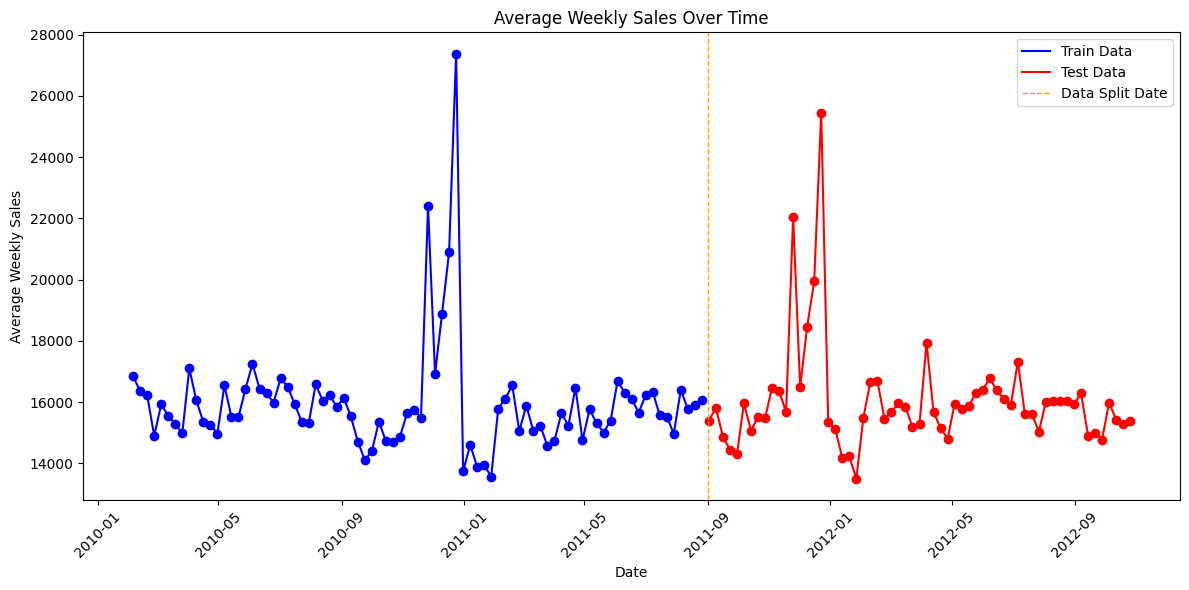

In [ ]:
plt.figure(figsize=(12, 6))

# Plot train data
avg_train_sales = train.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_train_sales.index, avg_train_sales.values, color='blue')
plt.plot(avg_train_sales.index, avg_train_sales.values, color='blue', label='Train Data')

# Plot test data
avg_test_sales = test.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_test_sales.index, avg_test_sales.values, color='red')
plt.plot(avg_test_sales.index, avg_test_sales.values, color='red', label='Test Data')

# Add Split Line
plt.axvline(pd.to_datetime(SPLIT_DATE), color='orange', linestyle='--', lw=1, label='Data Split Date')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
X_train = train.copy()
y_train = X_train['Weekly_Sales']
X_train.drop('Weekly_Sales', axis=1, inplace=True)

X_test = test.copy()
y_test = X_test['Weekly_Sales']
X_test.drop('Weekly_Sales', axis=1, inplace=True)

# Feature Engineering

In [ ]:
class PrepareFeaturesNoCat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Split date into 3 separate features
        date_field = pd.to_datetime(X['Date'])
        X['Date'] = date_field
        X['Year'] = date_field.dt.year
        X['Month'] = date_field.dt.month
        X['Day'] = date_field.dt.day

        # Represent booleans as 1 and 0
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)

        # Cast type into category to let model handle it
        X['Type'] = X['Type'].map({
          'A': 0,
          'B': 1,
          'C': 2
        })

        # Drop date field not to confuse model
        X.drop('Date', axis=1, inplace=True)

        return X

In [44]:
class AddGroupFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.group_means = {}
      self.group_medians = {}
      self.group_max = {}
      self.group_min = {}

    def fit(self, X, y):
      X = X.copy()
      X['Weekly_Sales'] = y
      self.group_means = X.groupby(["Store", "Dept"])["Weekly_Sales"].mean().to_dict()
      self.group_medians = X.groupby(["Store", "Dept"])["Weekly_Sales"].median().to_dict()
      self.group_max = X.groupby(["Store", "Dept"])["Weekly_Sales"].max().to_dict()
      self.group_min = X.groupby(["Store", "Dept"])["Weekly_Sales"].min().to_dict()
      return self

    def transform(self, X, y=None):
      X = X.copy()

      X["Group_Mean_Weekly_Sales"] = X[["Store", "Dept"]].apply(
        lambda row: self.group_means.get((row["Store"], row["Dept"]), np.nan),
        axis=1
      )
      X["Group_Median_Weekly_Sales"] = X[["Store", "Dept"]].apply(
        lambda row: self.group_medians.get((row["Store"], row["Dept"]), np.nan),
        axis=1
      )
      X["Group_Max_Weekly_Sales"] = X[["Store", "Dept"]].apply(
        lambda row: self.group_max.get((row["Store"], row["Dept"]), np.nan),
        axis=1
      )
      X["Group_Min_Weekly_Sales"] = X[["Store", "Dept"]].apply(
        lambda row: self.group_min.get((row["Store"], row["Dept"]), np.nan),
        axis=1
      )

      return X

In [49]:
a = AddGroupFeatures()
a.fit(X_train, y_train)

AddGroupFeatures()

In [47]:
a.transform(X_train)

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Group_Mean_Weekly_Sales,Group_Median_Weekly_Sales,Group_Max_Weekly_Sales,Group_Min_Weekly_Sales
0,1,1,2010-02-05,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,22418.13061,18327.96,57258.43,14537.37
1,1,1,2010-02-12,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,22418.13061,18327.96,57258.43,14537.37
2,1,1,2010-02-19,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,22418.13061,18327.96,57258.43,14537.37
3,1,1,2010-02-26,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,22418.13061,18327.96,57258.43,14537.37
4,1,1,2010-03-05,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,22418.13061,18327.96,57258.43,14537.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421504,45,98,2011-07-29,False,81.31,3.829,NaN,NaN,NaN,NaN,NaN,186.295596,8.625,B,118221,425.65473,265.00,1504.71,2.00
421505,45,98,2011-08-05,False,78.22,3.842,NaN,NaN,NaN,NaN,NaN,186.373404,8.625,B,118221,425.65473,265.00,1504.71,2.00
421506,45,98,2011-08-12,False,77.00,3.812,NaN,NaN,NaN,NaN,NaN,186.451211,8.625,B,118221,425.65473,265.00,1504.71,2.00
421507,45,98,2011-08-19,False,72.98,3.747,NaN,NaN,NaN,NaN,NaN,186.509307,8.625,B,118221,425.65473,265.00,1504.71,2.00


In [76]:
class AddLags(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
      self.lags = lags
      self.cache = {}

    def fit(self, X, y):
      X = X.copy()
      X['Date'] = pd.to_datetime(X['Date'])
      X['Weekly_Sales'] = y

      # For each (Store, Dept) cache lags for forecasting
      unique_store_dept = self.get_unique_store_dept(X)

      for store, dept in unique_store_dept:
        subset = X[(X['Store'] == store) & (X['Dept'] == dept)]
        subset = subset.sort_values(by='Date', ascending=True)

        self.cache[(store, dept)] = dict(zip(subset["Date"], subset["Weekly_Sales"]))

      # # Sample cache
      # print("Cache (1,1)", self.cache[(1,1)])

      return self

    def get_unique_store_dept(self, X):
      return X[['Store', 'Dept']].drop_duplicates().to_numpy()

    def get_cache(self, row, lag):
      dt = row['Date']
      store = row['Store']
      dept = row['Dept']

      if not (store, dept) in self.cache:
        return np.nan
      c = self.cache[(store, dept)]
      key = dt - pd.DateOffset(days=lag)

      if not key in c:
        return np.nan

      return c[key]

    # Precondition X should contain Weekly_Sales
    def transform(self, X, y=None):
      X = X.copy()

      # Create lag features
      for lag in self.lags:
        X[f'Weekly_Sales_Lag_{lag}'] = X.apply(lambda row: self.get_cache(row, lag), axis=1)

      return X

In [77]:
l = AddLags(lags=[7*51, 7*52, 7*53])
l.fit(X_train, y_train)

AddLags(lags=[357, 364, 371])

In [78]:
k = l.transform(X_train)

In [79]:
k.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly_Sales_Lag_357,Weekly_Sales_Lag_364,Weekly_Sales_Lag_371
0,1,1,2010-02-05,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,NaN,NaN,NaN
1,1,1,2010-02-12,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,NaN,NaN,NaN
2,1,1,2010-02-19,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,NaN,NaN,NaN
3,1,1,2010-02-26,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,NaN,NaN,NaN
4,1,1,2010-03-05,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,NaN,NaN,NaN


In [ ]:
pipeline1 = Pipeline([
    ('prepare_features', PrepareFeaturesNoCat()),
])
pipeline1.fit(X_train)

Pipeline(steps=[('prepare_features', PrepareFeaturesNoCat())])

In [ ]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Preprocessor_1"):
    mlflow.log_params({
        "pipeline": ["prepare_features_no_categories"]
    })
    mlflow.sklearn.log_model(pipeline1, "LightGBM_Preprocessor")

2025/07/08 03:18:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/08 03:18:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Preprocessor_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/f10885aaa0314e829eb72e4c9bb52ec9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [51]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Preprocessor_2"):
    mlflow.log_params({
        "pipeline": ["prepare_features_no_categories", "add_group_features"]
    })
    mlflow.sklearn.log_model(pipeline2, "LightGBM_Preprocessor")

2025/07/08 12:25:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/08 12:25:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Preprocessor_2 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/38ef0599149641b9b7401f3d21a4d136
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [50]:
pipeline2 = Pipeline([
    ('prepare_features', PrepareFeaturesNoCat()),
    ('add_group_features', AddGroupFeatures()),
])
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('prepare_features', PrepareFeaturesNoCat()),
                ('add_group_features', AddGroupFeatures())])

In [81]:
pipeline3 = Pipeline([
    ('add_lags', AddLags(lags=[7*51, 7*52, 7*53])),
    ('prepare_features', PrepareFeaturesNoCat()),
    ('add_group_features', AddGroupFeatures()),
])
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('add_lags', AddLags(lags=[357, 364, 371])),
                ('prepare_features', PrepareFeaturesNoCat()),
                ('add_group_features', AddGroupFeatures())])

In [82]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Preprocessor_3"):
    mlflow.log_params({
        "pipeline": ["add_lags", "prepare_features_no_categories", "add_group_features"]
    })
    mlflow.sklearn.log_model(pipeline3, "LightGBM_Preprocessor")

2025/07/08 15:00:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/08 15:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Preprocessor_3 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/b6f98da9747d4af0a504ed969ba141fd
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [83]:
X_train_processed = pipeline3.transform(X_train)
X_test_processed = pipeline3.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [85]:
X_train_processed.tail()

,Store,Dept,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Weekly_Sales_Lag_357,Weekly_Sales_Lag_364,Weekly_Sales_Lag_371,Year,Month,Day,Group_Mean_Weekly_Sales,Group_Median_Weekly_Sales,Group_Max_Weekly_Sales,Group_Min_Weekly_Sales
421504,45,98,0,81.31,3.829,NaN,NaN,NaN,NaN,NaN,...,8.25,5.50,8.25,2011,7,29,425.65473,265.0,1504.71,2.0
421505,45,98,0,78.22,3.842,NaN,NaN,NaN,NaN,NaN,...,NaN,8.25,5.50,2011,8,5,425.65473,265.0,1504.71,2.0
421506,45,98,0,77.00,3.812,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.25,2011,8,12,425.65473,265.0,1504.71,2.0
421507,45,98,0,72.98,3.747,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2011,8,19,425.65473,265.0,1504.71,2.0
421508,45,98,0,72.55,3.704,NaN,NaN,NaN,NaN,NaN,...,26.00,NaN,NaN,2011,8,26,425.65473,265.0,1504.71,2.0


In [86]:
weights_train = X_train_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1)
weights_test = X_test_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1)

In [87]:
train_dataset = lgb.Dataset(X_train_processed, label=y_train, weight=weights_train)
test_dataset = lgb.Dataset(X_test_processed, label=y_test, weight=weights_test)

In [88]:
def WMAE(dataset, real, predict):
  weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
  return (np.sum(weights * abs(real - predict)) / np.sum(weights))

In [89]:
def get_metrics(model, tr, tr_y, val, val_y):
    # Train score
    y_tr_pred = model.predict(tr)
    mae_tr = mean_absolute_error(tr_y, y_tr_pred)
    wmae_tr = WMAE(tr, tr_y, y_tr_pred)

    # Test score
    y_val_pred = model.predict(val)
    mae_val = mean_absolute_error(val_y, y_val_pred)
    wmae_val = WMAE(val, val_y, y_val_pred)

    metrics = {
        'mae_train': mae_tr,
        'mae_test': mae_val,
        'wmae_train': wmae_tr,
        'wmae_test': wmae_val
    }

    print(metrics)

    return metrics


In [90]:
def plot_store_dept(model, store, dept):
  train_view = train[(train['Store'] == store) & (train['Dept'] == dept)]
  test_view = test[(test['Store'] == store) & (test['Dept'] == dept)]
  X_test_view = X_test_processed[(X_test_processed['Store'] == store) & (X_test_processed['Dept'] == dept)]
  X_train_view = X_train_processed[(X_train_processed['Store'] == store) & (X_train_processed['Dept'] == dept)]

  pred_pd = pd.DataFrame({
      'Date': test_view['Date'],
      'Weekly_Sales': model.predict(X_test_view)
  })

  pred_train_pd = pd.DataFrame({
      'Date': train_view['Date'],
      'Weekly_Sales': model.predict(X_train_view)
  })

  plot_predictions_store_dept(
      train=train_view,
      test=test_view,
      pred=pred_pd,
      pred_train=pred_train_pd,
      store=store,
      dept=dept)

def plot_predictions_store_dept(train, test, pred, pred_train, store, dept):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred_train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='orange', label='Train Prediction')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Weekly Sales')
  plt.title(f'Weekly Sales for ({store}, {dept})')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save plot to upload later to mlflow
  # plt.savefig("prediction.png")

  plt.show()

In [102]:
def plot_avg(model):

  pred_pd = pd.DataFrame({
      'Date': test['Date'],
      'Weekly_Sales': model.predict(X_test_processed)
  })

  pred_train_pd = pd.DataFrame({
      'Date': train['Date'],
      'Weekly_Sales': model.predict(X_train_processed)
  })

  plot_predictions_avg(
      train=train,
      test=test,
      pred=pred_pd,
      pred_train=pred_train_pd,
  )

def plot_predictions_avg(train, test, pred, pred_train):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred_train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='orange', label='Train Prediction')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Weekly Sales')
  plt.title('Average Weekly Sales For All (Store, Dept)')
  plt.xticks(rotation=45)
  plt.tight_layout()

  plt.show()

# Experiments

## Experiment 1

In [35]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 8980.64	valid_1's l1: 9325.06
[20]	training's l1: 7325.08	valid_1's l1: 7660.27
[30]	training's l1: 6432.87	valid_1's l1: 6784.15
[40]	training's l1: 5919.72	valid_1's l1: 6286.75
[50]	training's l1: 5496.33	valid_1's l1: 5922.54
[60]	training's l1: 5191.24	valid_1's l1: 5644.51
[70]	training's l1: 4970.8	valid_1's l1: 5435.84
[80]	training's l1: 4807.73	valid_1's l1: 5283.62
[90]	training's l1: 4684.09	valid_1's l1: 5172.3
[100]	training's l1: 4561.76	valid_1's l1: 5067.06
[110]	training's l1: 4454.18	valid_1's l1: 4982.84
[120]	training's l1: 4391.01	valid_1's l

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

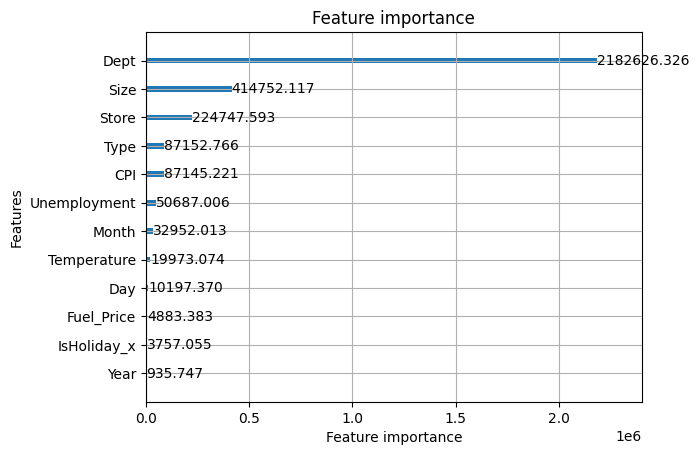

In [36]:
lgb.plot_importance(model, importance_type="gain")

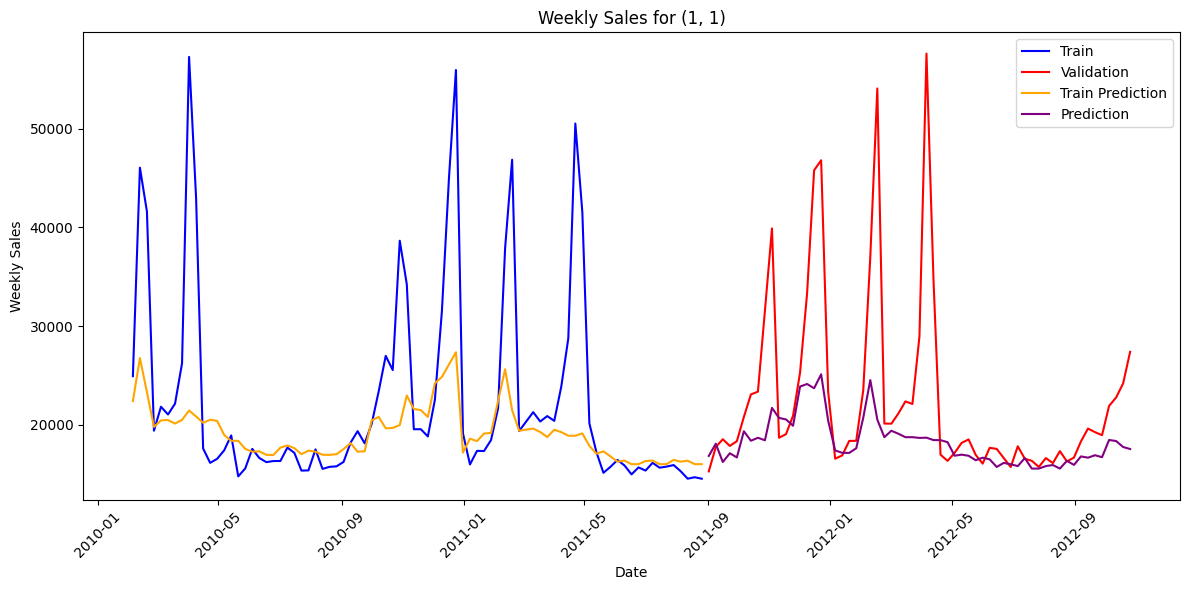

In [ ]:
plot_store_dept(model, 1, 1)

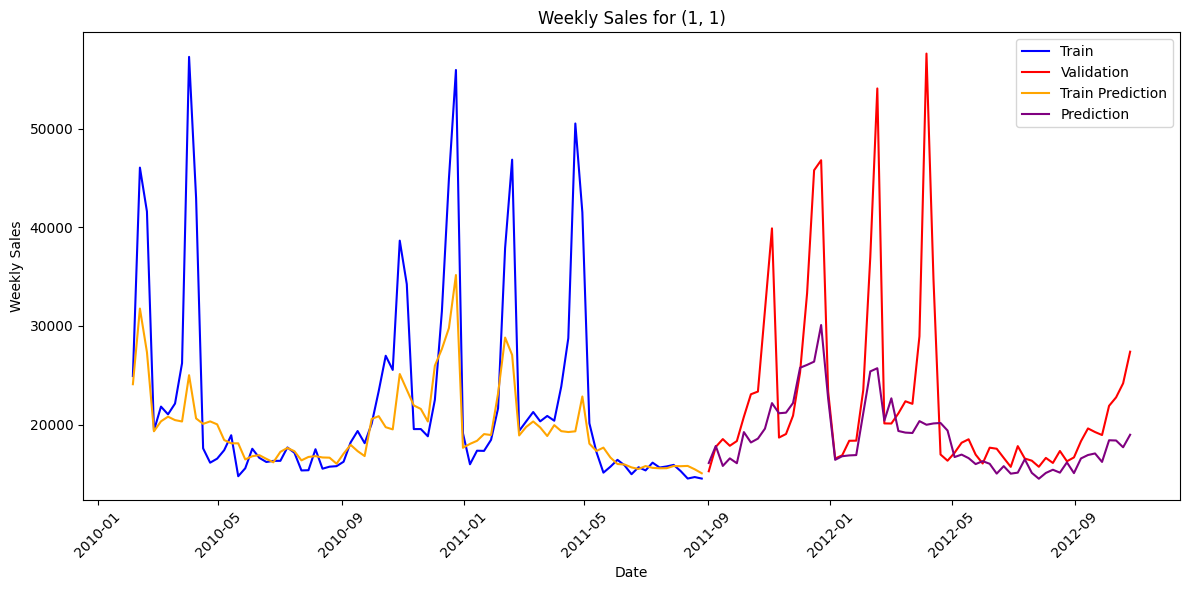

In [ ]:
plot_store_dept(model, 1, 1)

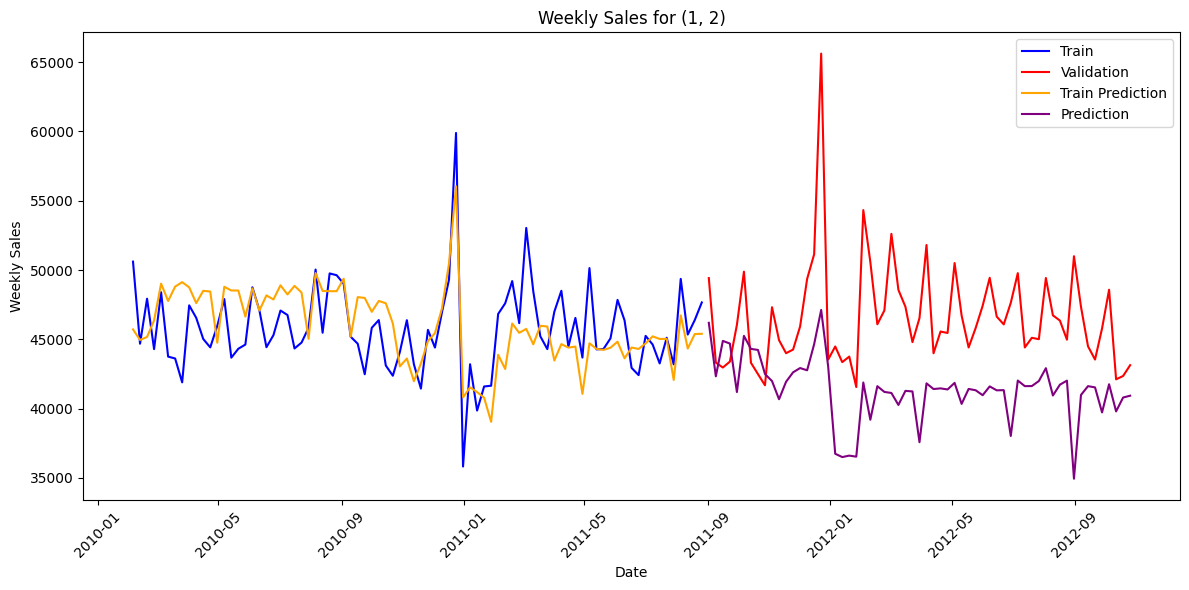

In [ ]:
plot_store_dept(model, 1, 2)

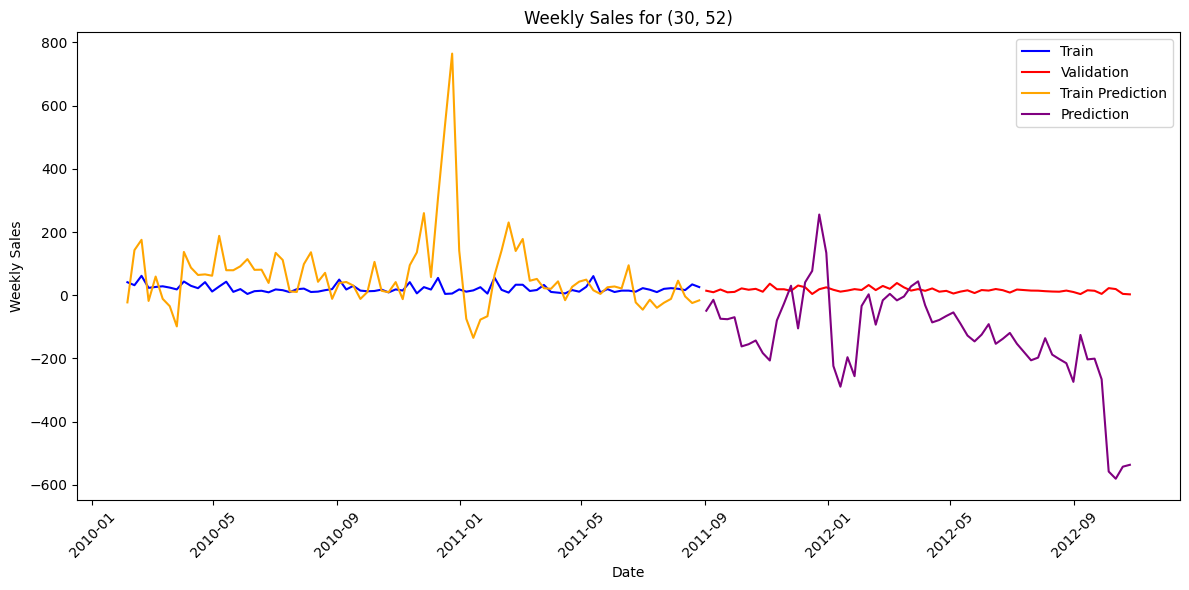

In [ ]:
plot_store_dept(model, 30, 52)

In [ ]:
import mlflow
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Objective_MAE_Booster_500"):
    mlflow.log_params(training_params)
    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 10:38:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_MAE_Booster_500 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/308469165f9446e9bdb7bbebf5f0d414
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


## Experiment 2: Reducing LR

In [ ]:
training_params = {
    "params": {
      "learning_rate": 0.05,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 10441.2	valid_1's l1: 10801.2
[20]	training's l1: 8928.51	valid_1's l1: 9277.04
[30]	training's l1: 7960.37	valid_1's l1: 8308.15
[40]	training's l1: 7378.49	valid_1's l1: 7734.98
[50]	training's l1: 6873.43	valid_1's l1: 7236.98
[60]	training's l1: 6427.46	valid_1's l1: 6798.84
[70]	training's l1: 6081.34	valid_1's l1: 6460.9
[80]	training's l1: 5866.53	valid_1's l1: 6254.62
[90]	training's l1: 5638.36	valid_1's l1: 6027.17
[100]	training's l1: 5462.27	valid_1's l1: 5855.68
[110]	training's l1: 5318.45	valid_1's l1: 5740.61
[120]	training's l1: 5221.64	valid_1's 

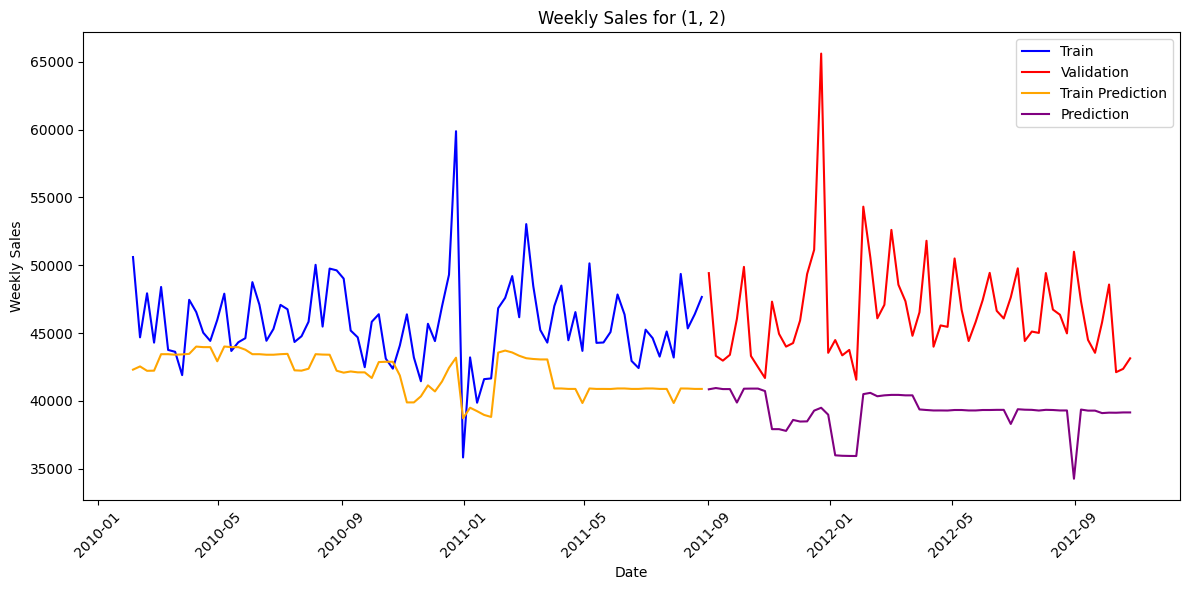

In [ ]:
plot_store_dept(model, 1, 2)

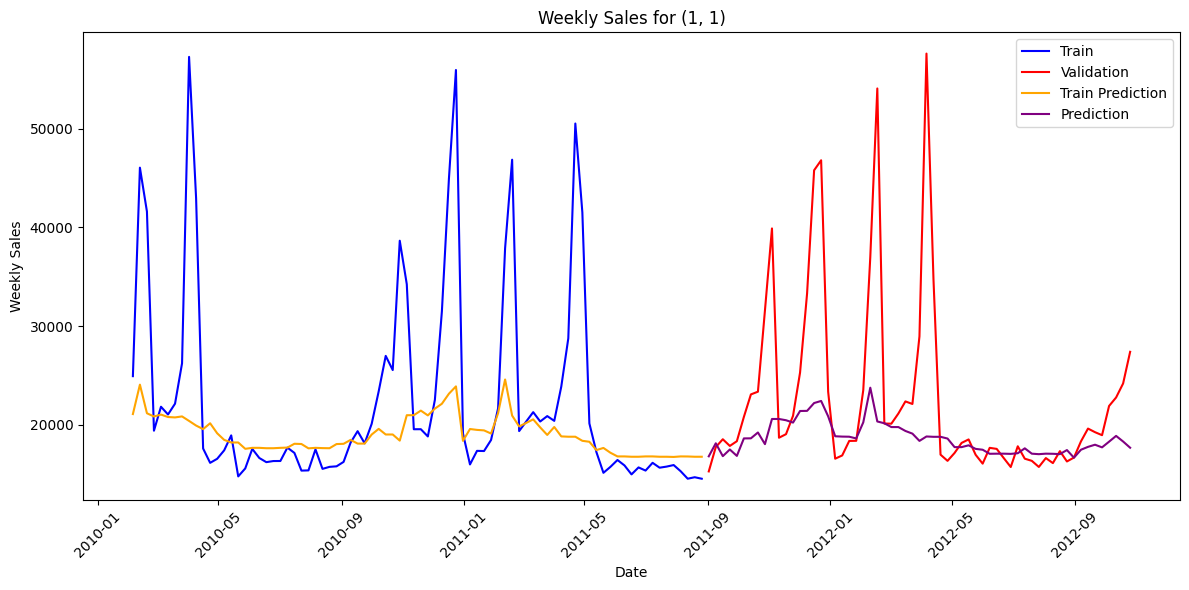

In [ ]:
plot_store_dept(model, 1, 1)

In [ ]:
import mlflow
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Objective_MAE_Booster_200_LR_0.05"):
    mlflow.log_params(training_params)
    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 04:09:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_MAE_Booster_200_LR_0.5 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/e0cc08c58f184578a8095fb3b10ea867
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [ ]:
training_params = {
    "params": {
      "learning_rate": 0.01,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 12695.2	valid_1's l1: 13043.1
[20]	training's l1: 12025.4	valid_1's l1: 12378.5
[30]	training's l1: 11434.9	valid_1's l1: 11789.9
[40]	training's l1: 10892.3	valid_1's l1: 11252
[50]	training's l1: 10517.5	valid_1's l1: 10879.4
[60]	training's l1: 10188.2	valid_1's l1: 10549.7
[70]	training's l1: 9857.31	valid_1's l1: 10217.6
[80]	training's l1: 9546.42	valid_1's l1: 9906.97
[90]	training's l1: 9265.91	valid_1's l1: 9624.15
[100]	training's l1: 9011.02	valid_1's l1: 9366.8
[110]	training's l1: 8758.88	valid_1's l1: 9112.96
[120]	training's l1: 8545.96	valid_1's l1

In [ ]:
import mlflow
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Objective_MAE_Booster_200_LR_0.01"):
    mlflow.log_params(training_params)
    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 04:12:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_MAE_Booster_200_LR_0.01 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/67f56e7508ca4017a2e09b5fdb8b4ddf
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


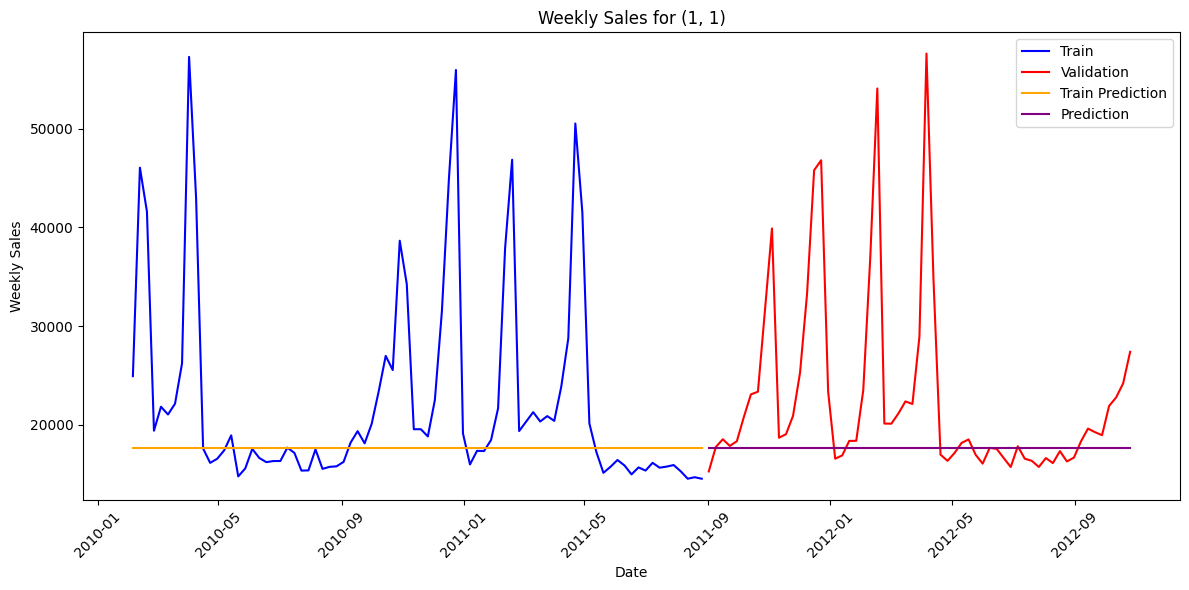

In [ ]:
plot_store_dept(model, 1, 1)

## Experiment 3: Objective SquaredError

In [31]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "regression",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 2.04251e+08	valid_1's l2: 2.2321e+08
[20]	training's l2: 1.33156e+08	valid_1's l2: 1.48653e+08
[30]	training's l2: 1.01837e+08	valid_1's l2: 1.20536e+08
[40]	training's l2: 8.2535e+07	valid_1's l2: 1.03519e+08
[50]	training's l2: 7.13224e+07	valid_1's l2: 9.50979e+07
[60]	training's l2: 6.36216e+07	valid_1's l2: 8.76652e+07
[70]	training's l2: 5.76004e+07	valid_1's l2: 8.18783e+07
[80]	training's l2: 5.27455e+07	valid_1's l2: 7.7263e+07
[90]	training's l2: 4.91495e+07	valid_1's l2: 7.40526e+07
[100]	training's l2: 4.58633e+07	valid_1's l2: 7.17275e+07
[110]	train

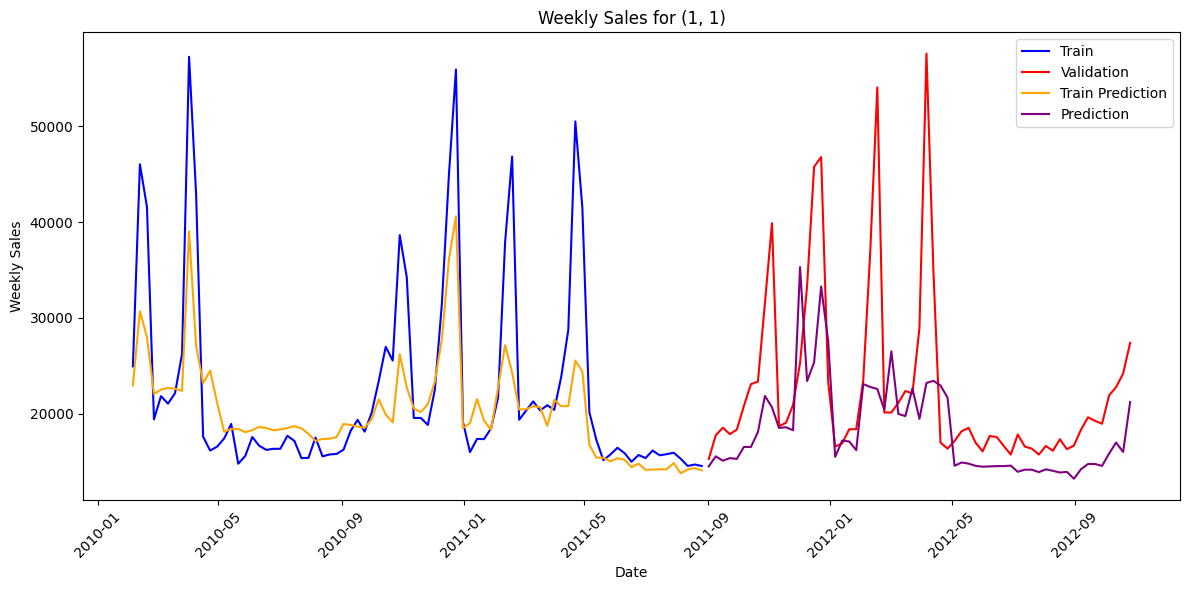

In [34]:
plot_store_dept(model, 1, 1)

In [ ]:
import mlflow
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Objective_Regression_Booster_1"):
    mlflow.log_params(training_params)
    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 05:00:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/27ef6d2c6b624ffdbc6a643e6f9ca043
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [ ]:
for n in [10, 50, 100, 200]:
  training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "regression",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": n,
  }
  model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
  )
  metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

  mlflow.set_experiment("LightGBM_Training")
  mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

  with mlflow.start_run(run_name=f"LightGBM_Objective_Regression_Booster_{n}"):
    mlflow.log_params(training_params)
    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "LightGBM Model")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 2.04251e+08	valid_1's l2: 2.2321e+08
{'mae_train': 9118.293422087148, 'mae_test': 9421.064526131733, 'wmae_train': np.float64(9217.33373820311), 'wmae_test': np.float64(9585.955283129553)}


2025/07/08 05:03:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_10 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/0f2ddb74a23e43c2b410188bf6c6b662
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 2.04251e+08	valid_1's l2: 2.2321e+08
[20]	training's l2: 1.33156e+08	valid_1's l2: 1.48653e+08
[30]	training's l2: 1.01837e+08	valid_1's l2: 1.20536e+08
[40]	training's l2: 8.2535e+07	valid_1's l2: 1.03519e+08
[50]	training's l2: 7.13224e+07	valid_1's l2: 9.50979e+07
{'mae_train': 5126.293436943, 'mae_

2025/07/08 05:03:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_50 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/4f7af445afd94ea4b81c42e59f79d9f3
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 2.04251e+08	valid_1's l2: 2.2321e+08
[20]	training's l2: 1.33156e+08	valid_1's l2: 1.48653e+08
[30]	training's l2: 1.01837e+08	valid_1's l2: 1.20536e+08
[40]	training's l2: 8.2535e+07	valid_1's l2: 1.03519e+08
[50]	training's l2: 7.13224e+07	valid_1's l2: 9.50979e+07
[60]	training's l2: 6.36216e+07	val

2025/07/08 05:03:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/241f999b6ae644ba8be9d55c59235505
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 2.04251e+08	valid_1's l2: 2.2321e+08
[20]	training's l2: 1.33156e+08	valid_1's l2: 1.48653e+08
[30]	training's l2: 1.01837e+08	valid_1's l2: 1.20536e+08
[40]	training's l2: 8.2535e+07	valid_1's l2: 1.03519e+08
[50]	training's l2: 7.13224e+07	valid_1's l2: 9.50979e+07
[60]	training's l2: 6.36216e+07	va

2025/07/08 05:04:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_200 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/7e0771daa84049d1b90d438481b97018
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [ ]:
training_params = {
  "params": {
    "learning_rate": 0.01,
    "objective": "regression",
    "random_state": 42,
    "deterministic": True,
  },
  "num_boost_round": 200,
}
model = lgb.train(
  **training_params,
  train_set=train_dataset,
  valid_sets=[train_dataset, test_dataset],
  callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_Objective_Regression_Booster_200_LR_0.01"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 12
[LightGBM] [Info] Start training from score 16112.752371
[10]	training's l2: 4.81447e+08	valid_1's l2: 5.11963e+08
[20]	training's l2: 4.24672e+08	valid_1's l2: 4.526e+08
[30]	training's l2: 3.77902e+08	valid_1's l2: 4.03725e+08
[40]	training's l2: 3.38789e+08	valid_1's l2: 3.62961e+08
[50]	training's l2: 3.06997e+08	valid_1's l2: 3.29748e+08
[60]	training's l2: 2.81455e+08	valid_1's l2: 3.03194e+08
[70]	training's l2: 2.59628e+08	valid_1's l2: 2.80288e+08
[80]	training's l2: 2.42074e+08	valid_1's l2: 2.61661e+08
[90]	training's l2: 2.26817e+08	valid_1's l2: 2.45787e+08
[100]	training's l2: 2.11919e+08	valid_1's l2: 2.30065e+08
[110]	trai

2025/07/08 05:07:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Objective_Regression_Booster_200_LR_0.01 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/8e58fd203a874a4e8783acfb7ba1dc21
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


## Experiment 4: Group Features

In [59]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 100,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 16
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 6784.09	valid_1's l1: 7199.23
[20]	training's l1: 4086.26	valid_1's l1: 4525.13
[30]	training's l1: 3066.1	valid_1's l1: 3501.46
[40]	training's l1: 2657.69	valid_1's l1: 3109.69
[50]	training's l1: 2515.06	valid_1's l1: 2973.18
[60]	training's l1: 2431.58	valid_1's l1: 2888.82
[70]	training's l1: 2384.39	valid_1's l1: 2855.12
[80]	training's l1: 2318.49	valid_1's l1: 2803.14
[90]	training's l1: 2292.09	valid_1's l1: 2784.32
[100]	training's l1: 2260.97	valid_1's l1: 2763.87
{'mae_train': 2084.999485440237, 'mae_test': 2504.721237950218, 'wmae_train': np.float64(2

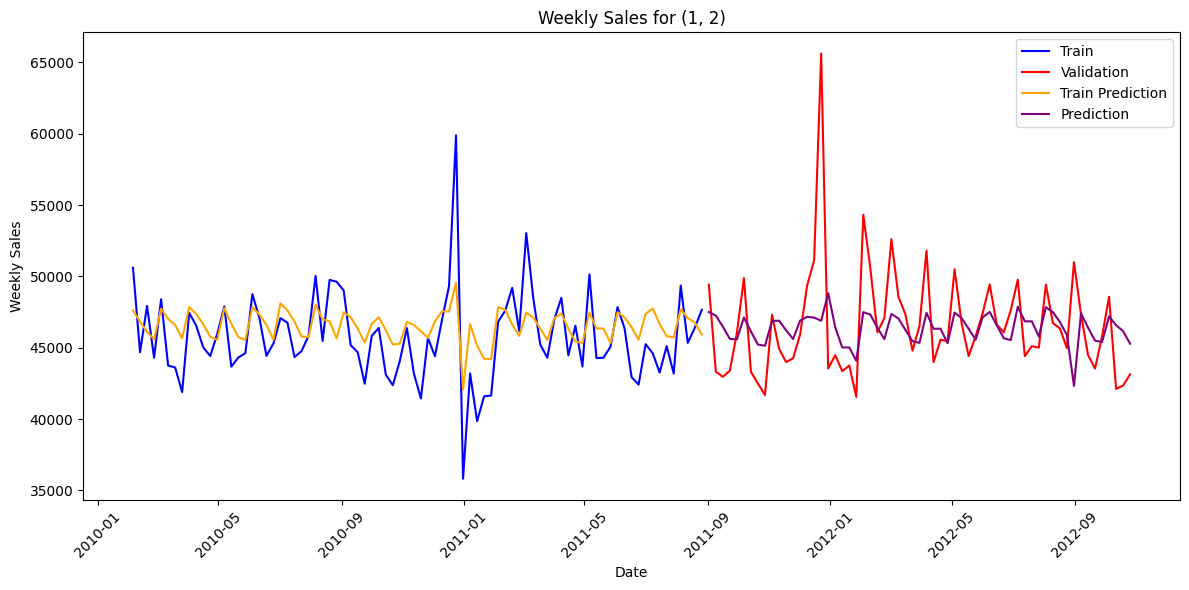

In [62]:
plot_store_dept(model, 1, 2)

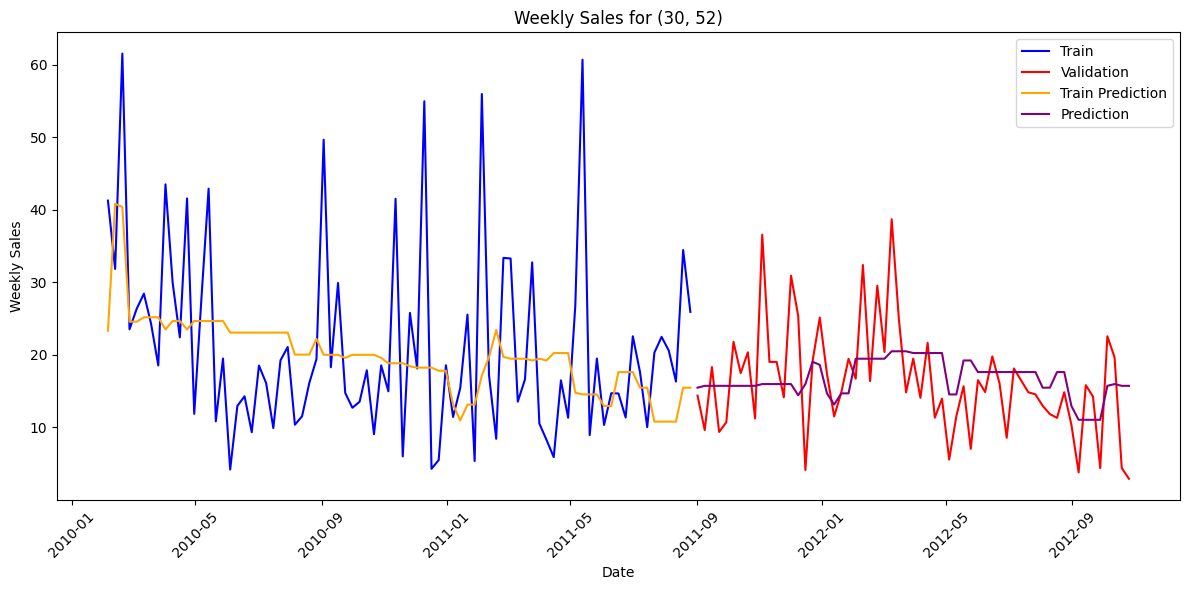

In [64]:
plot_store_dept(model, 30, 52)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

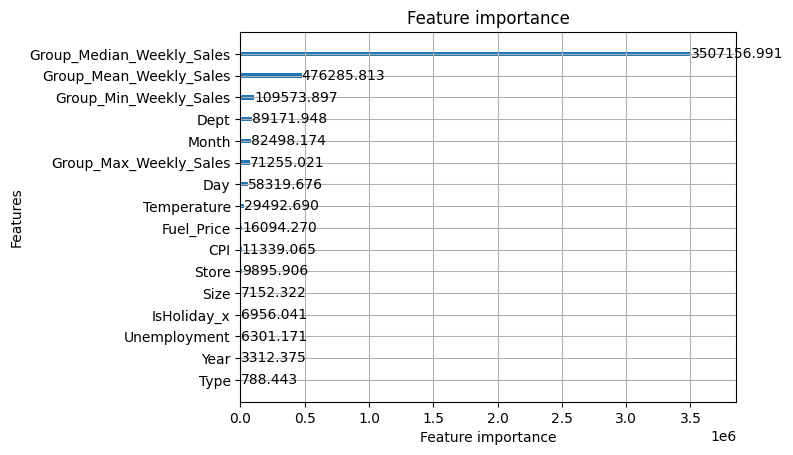

In [63]:
lgb.plot_importance(model, importance_type="gain")

In [65]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupFeats_Objective_MAE_Booster_100"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 12:45:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupFeats_Objective_MAE_Booster_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/f39f49481a7443778385cff6c90d8fb6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [69]:
training_params = {
    "params": {
      "learning_rate": 0.03,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 16
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 10866.7	valid_1's l1: 11234.5
[20]	training's l1: 8781.95	valid_1's l1: 9181.7
[30]	training's l1: 7187.6	valid_1's l1: 7609.94
[40]	training's l1: 5985.8	valid_1's l1: 6422.72
[50]	training's l1: 5078.58	valid_1's l1: 5524.62
[60]	training's l1: 4405.46	valid_1's l1: 4854.38
[70]	training's l1: 3917.94	valid_1's l1: 4366.98
[80]	training's l1: 3549.99	valid_1's l1: 3997.82
[90]	training's l1: 3269.73	valid_1's l1: 3715.14
[100]	training's l1: 3051.17	valid_1's l1: 3497.3
[110]	training's l1: 2893.56	valid_1's l1: 3342.5
[120]	training's l1: 2765.68	valid_1's l1: 

In [70]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 13:56:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/b6a958bb95be4076b8a0fed89d737405
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [72]:
training_params = {
    "params": {
      "learning_rate": 0.03,
      "objective": "mae",
      "max_depth": 1,
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 16
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 11417.7	valid_1's l1: 11786.8
[20]	training's l1: 9925.32	valid_1's l1: 10317.5
[30]	training's l1: 8921.69	valid_1's l1: 9321.15
[40]	training's l1: 8094.29	valid_1's l1: 8507.16
[50]	training's l1: 7474.86	valid_1's l1: 7892.5
[60]	training's l1: 6882.5	valid_1's l1: 7303
[70]	training's l1: 6419.11	valid_1's l1: 6840.85
[80]	training's l1: 6086.71	valid_1's l1: 6509.92
[90]	training's l1: 5729.99	valid_1's l1: 6157.12
[100]	training's l1: 5489.13	valid_1's l1: 5916.18
[110]	training's l1: 5261.57	valid_1's l1: 5691.94
[120]	training's l1: 5051.63	valid_1's l1: 

In [73]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03_MaxDepth_1"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 14:05:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03_MaxDepth_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/660b2a4a7f83422593af6e527c3d7821
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [74]:
training_params = {
    "params": {
      "learning_rate": 0.03,
      "objective": "mae",
      "max_depth": 2,
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 200,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 16
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 11000.9	valid_1's l1: 11367.7
[20]	training's l1: 9042.31	valid_1's l1: 9430.5
[30]	training's l1: 7526.89	valid_1's l1: 7931.17
[40]	training's l1: 6370.76	valid_1's l1: 6781.2
[50]	training's l1: 5494.05	valid_1's l1: 5911.2
[60]	training's l1: 4830.84	valid_1's l1: 5252.89
[70]	training's l1: 4410.14	valid_1's l1: 4833.74
[80]	training's l1: 4121	valid_1's l1: 4543.87
[90]	training's l1: 3844.51	valid_1's l1: 4268.67
[100]	training's l1: 3645.95	valid_1's l1: 4070.46
[110]	training's l1: 3500.52	valid_1's l1: 3925.53
[120]	training's l1: 3382.13	valid_1's l1: 3

In [75]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03_MaxDepth_2"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 14:08:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupFeats_Objective_MAE_Booster_200_LR_0.03_MaxDepth_2 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/cf18aa2d007747fd936f4d3c3dc6ce79
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


## Experiment 5: Lag + Group Features

In [91]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 100,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 19
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 6768.82	valid_1's l1: 7137.4
[20]	training's l1: 4059.73	valid_1's l1: 4391.17
[30]	training's l1: 3037.87	valid_1's l1: 3322.28
[40]	training's l1: 2622.28	valid_1's l1: 2894.58
[50]	training's l1: 2467.9	valid_1's l1: 2730.7
[60]	training's l1: 2402.49	valid_1's l1: 2667.75
[70]	training's l1: 2348.77	valid_1's l1: 2613.8
[80]	training's l1: 2319.77	valid_1's l1: 2590.02
[90]	training's l1: 2291.81	valid_1's l1: 2566.91
[100]	training's l1: 2248.88	valid_1's l1: 2535.15
{'mae_train': 2051.544241439307, 'mae_test': 2269.138472935298, 'wmae_train': np.float64(2248

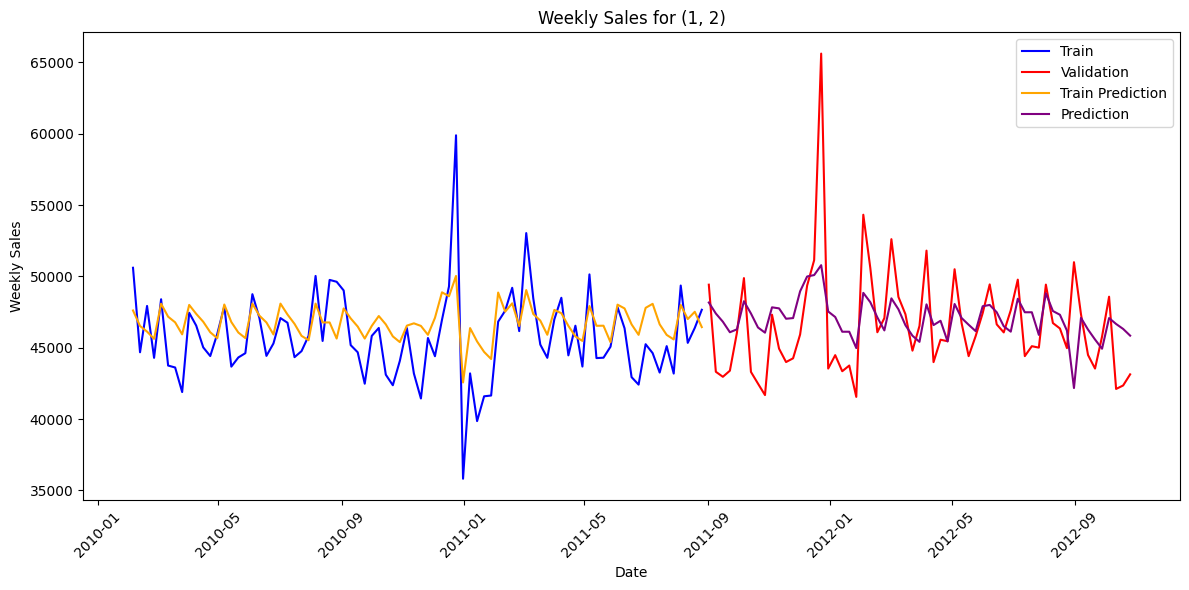

In [92]:
plot_store_dept(model, 1, 2)

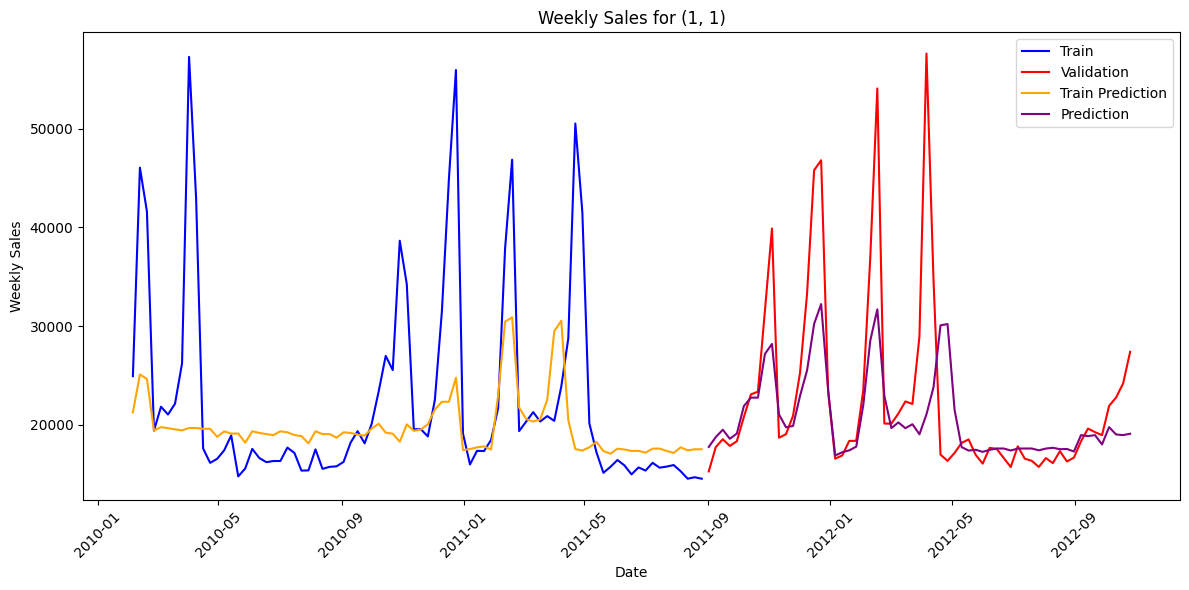

In [95]:
plot_store_dept(model, 1, 1)

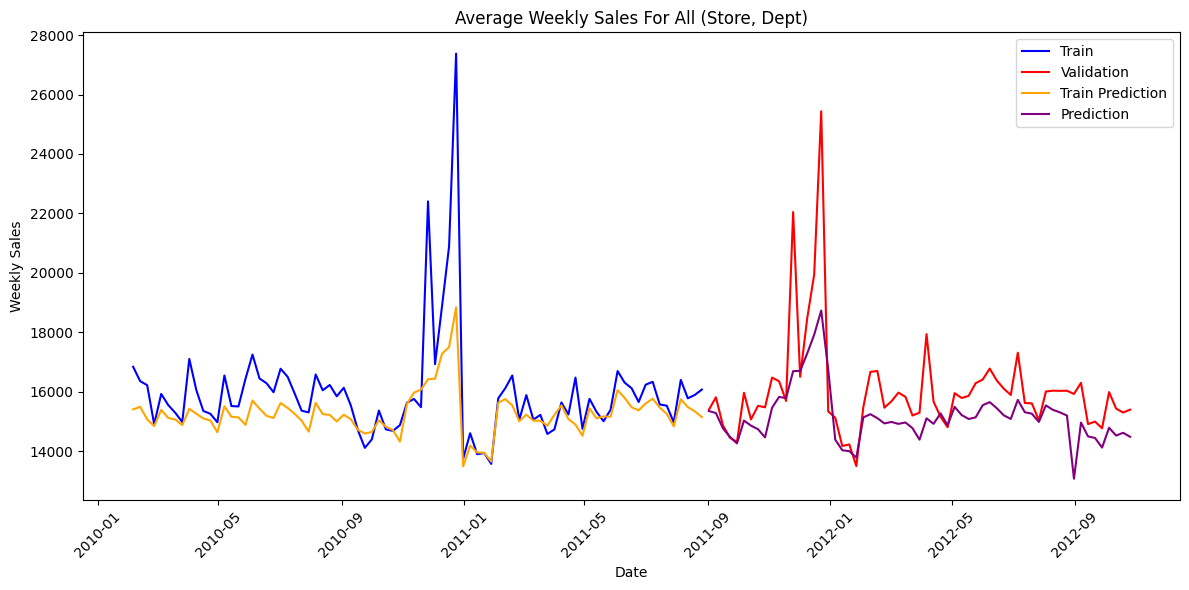

In [103]:
plot_avg(model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

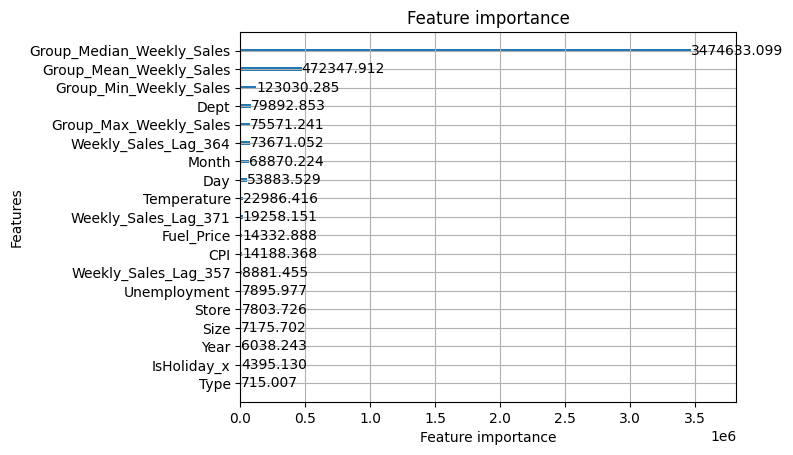

In [96]:
lgb.plot_importance(model, importance_type="gain")

In [97]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupLagFeats_Objective_MAE_Booster_100"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 15:15:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupLagFeats_Objective_MAE_Booster_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/43a826d6d18e473fb689a3cee2d7ad3d
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [104]:
import shap
explainer = shap.Explainer(model)

In [105]:
shap_values = explainer(X_test_processed)

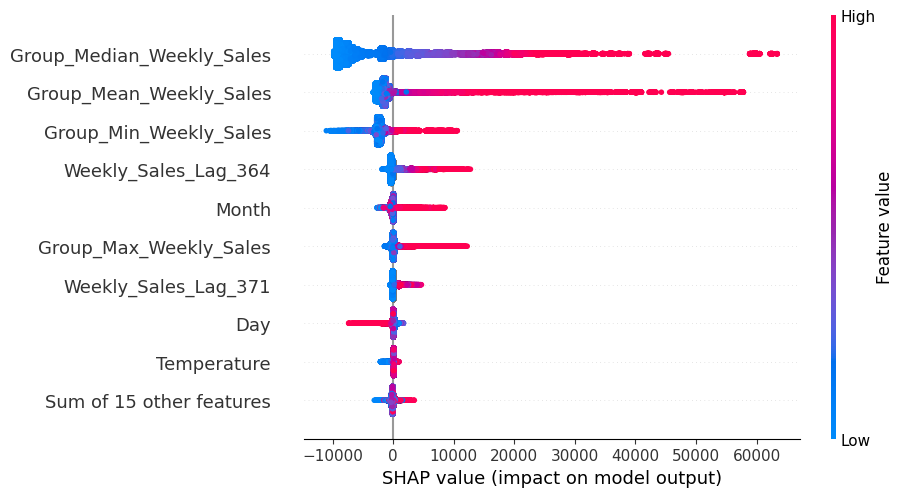

In [106]:
shap.plots.beeswarm(shap_values)

In [132]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 150,
}
model = lgb.train(
    **training_params,
    train_set=train_dataset,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.log_evaluation(10)]
)
metrics = get_metrics(model, tr=X_train_processed, tr_y=y_train, val=X_test_processed, val_y=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 240603, number of used features: 19
[LightGBM] [Info] Start training from score 7756.139648
[10]	training's l1: 6768.82	valid_1's l1: 7137.4
[20]	training's l1: 4059.73	valid_1's l1: 4391.17
[30]	training's l1: 3037.87	valid_1's l1: 3322.28
[40]	training's l1: 2622.28	valid_1's l1: 2894.58
[50]	training's l1: 2467.9	valid_1's l1: 2730.7
[60]	training's l1: 2402.49	valid_1's l1: 2667.75
[70]	training's l1: 2348.77	valid_1's l1: 2613.8
[80]	training's l1: 2319.77	valid_1's l1: 2590.02
[90]	training's l1: 2291.81	valid_1's l1: 2566.91
[100]	training's l1: 2248.88	valid_1's l1: 2535.15
[110]	training's l1: 2204.84	valid_1's l1: 2476.45
[120]	training's l1: 2181.3	valid_1's l1: 

In [133]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupLagFeats_Objective_MAE_Booster_150"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 16:50:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupLagFeats_Objective_MAE_Booster_150 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/c98228003bc14684a673e64cdebb18c9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


## Total Database Fit

In [109]:
X_total = df.copy()
y_total = df['Weekly_Sales']
X_total.drop(columns=['Weekly_Sales'], inplace=True)

In [110]:
pipeline_total = Pipeline([
    ('add_lags', AddLags(lags=[7*51, 7*52, 7*53])),
    ('prepare_features', PrepareFeaturesNoCat()),
    ('add_group_features', AddGroupFeatures()),
])
pipeline_total.fit(X_total, y_total)

Pipeline(steps=[('add_lags', AddLags(lags=[357, 364, 371])),
                ('prepare_features', PrepareFeaturesNoCat()),
                ('add_group_features', AddGroupFeatures())])

In [111]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="LightGBM_Preprocessor_3_Total_Dataset_Fit"):
    mlflow.log_params({
        "pipeline": ["add_lags", "prepare_features_no_categories", "add_group_features"]
    })
    mlflow.sklearn.log_model(pipeline_total, "LightGBM_Preprocessor")

2025/07/08 16:05:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/08 16:05:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_Preprocessor_3_Total_Dataset_Fit at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/c7bfab9f9b4e4f79bc7f3146e3768993
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


In [112]:
X_total_processed = pipeline_total.transform(X_total)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [113]:
weights_total = X_total_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1)

In [114]:
total_dataset = lgb.Dataset(X_total_processed, label=y_total, weight=weights_total)

In [131]:
training_params = {
    "params": {
      "learning_rate": 0.1,
      "objective": "mae",
      "random_state": 42,
      "deterministic": True,
    },
    "num_boost_round": 100,
}
model = lgb.train(
    **training_params,
    train_set=total_dataset,
    valid_sets=[total_dataset],
    callbacks=[lgb.log_evaluation(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 421570, number of used features: 24
[LightGBM] [Info] Start training from score 7680.639160
[10]	training's l1: 6740.34
[20]	training's l1: 3974.41
[30]	training's l1: 2944.9
[40]	training's l1: 2511.89
[50]	training's l1: 2334.48
[60]	training's l1: 2250.68
[70]	training's l1: 2202.7
[80]	training's l1: 2173.57
[90]	training's l1: 2139.63
[100]	training's l1: 2100.49


In [130]:
mlflow.set_experiment("LightGBM_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name=f"LightGBM_GroupLagFeats_Objective_MAE_Booster_100_TotalFit"):
  mlflow.log_params(training_params)
  mlflow.log_metrics(metrics)
  mlflow.lightgbm.log_model(model, "LightGBM Model")

2025/07/08 16:43:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_GroupLagFeats_Objective_MAE_Booster_100_TotalFit_Regularization_3 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10/runs/139f572070ae4b9fa39c4c53117181ed
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/10


# Save to Dagshub

In [ ]:
from dagshub.notebook import save_notebook

save_notebook(repo="Cimbir/Store-Sales-Forecasting", path=".")